In [1]:
#auto reload 
%load_ext autoreload
%autoreload 2

In [2]:
from snake_env_ray import SnakeEnv
import mediapy as media
import pygame
import numpy as np

pygame 2.4.0 (SDL 2.26.4, Python 3.7.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/ajvendetta/.pyenv/versions/3.7.16/envs/bcirl/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
import yaml 
config = yaml.load(open("bc-irl-snake.yaml", "r"), Loader=yaml.FullLoader)
env_config = config["env"]["env_settings"]["params"]["config"]
env_config["render_mode"] = "human"

""

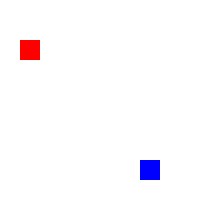

In [4]:
snakie = SnakeEnv(env_config)
snakie.render_mode = "rgb_array"
snakie.reset()
media.show_image(snakie.render())

In [5]:
import matplotlib.pyplot as plt

[0.  0.6]


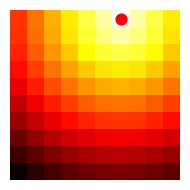

In [41]:
eval_env = SnakeEnv(env_config)
reward_map = np.zeros((eval_env.screen_width//eval_env.block_size, eval_env.screen_height//eval_env.block_size))
apple_pos = eval_env.reset()[0][:2]
print(apple_pos)
#test what you got so far by plotting a heat map of the reward using the snake only 
for x in range(eval_env.screen_width//eval_env.block_size):
    for y in range(eval_env.screen_height//eval_env.block_size ):
        x_grid = x * eval_env.block_size / eval_env.screen_width
        y_grid = y * eval_env.block_size / eval_env.screen_height
 
        reward_map[x,y] = 1.0-eval_env.normalized_distance((x_grid, y_grid), apple_pos)
fig, ax = plt.subplots(figsize=(2, 2))  # Adjust the figsize as desired

# Plot the reward map without axis and numbers
image = ax.imshow(reward_map, cmap='hot', interpolation='nearest')
ax.axis('off')

# Plot the apple
ax.scatter(
    apple_pos[1] * eval_env.screen_height // eval_env.block_size,
    apple_pos[0] * eval_env.screen_width // eval_env.block_size,

    c='red',
    s=60
)
plt.tight_layout()
plt.show()

In [7]:
from collections import deque

def to_grid(snakie):
    #transform the observation into a grid 
    image = np.zeros((snakie.screen_height//snakie.block_size, snakie.screen_width//snakie.block_size),dtype=np.uint8)

    #red for the apple 
    image[snakie.apple.position[0]//snakie.block_size, snakie.apple.position[1]//snakie.block_size] = 3

    #green for the snake
    for pos in snakie.snake.body:
        image[pos[0]//snakie.block_size, pos[1]//snakie.block_size,] = 1
    #blue for the head
    image[snakie.snake.head[0]//snakie.block_size, snakie.snake.head[1]//snakie.block_size,] = 2
    return image 

def find_shortest_path(grid, player_location, apple_position):
    rows, cols = len(grid), len(grid[0])
    queue = deque()
    visited = set()
    queue.append(player_location)
    visited.add(player_location)
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    path = {}

    while queue:
        current_cell = queue.popleft()
        if current_cell == apple_position:
            break

        for direction in directions:
            next_row = current_cell[0] + direction[0] 
            next_col = current_cell[1] + direction[1]
            next_cell = (next_row, next_col)
            print(player_location,next_cell)
            if 0 <= next_row < rows and 0 <= next_col < cols and grid[next_row][next_col] != 1 and next_cell not in visited:
                queue.append(next_cell)
                visited.add(next_cell)
                path[next_cell] = current_cell
    print(path)
    if apple_position not in path:
        return None

    # Reconstruct the path
    current_cell = apple_position
    while current_cell != player_location:
        parent_cell = path[current_cell]
        if (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (1, 0):
            action = 0
        elif (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (-1, 0):
            action = 1
        elif (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (0, 1):
            action = 2
        else:
            action = 3
        return action

In [8]:
import heapq

def astar(start, goal, walls):
    """
    A* algorithm implementation to find the shortest path from start to goal
    on a grid with walls represented as 1s.
    """
    # Define the heuristic function as the Manhattan distance
    def heuristic(node):
        return abs(node[0] - goal[0]) + abs(node[1] - goal[1])
    
    # Initialize the open and closed sets
    open_set = [(0, start)]
    closed_set = set()
    
    # Initialize the g score for the start node
    g_score = {start: 0}
    
    # Initialize the parent dictionary to keep track of the path
    parent = {}
    
    while open_set:
        # Get the node with the lowest f score from the open set
        current = heapq.heappop(open_set)[1]
        
        # If we've reached the goal, reconstruct the path and return it
        if current == goal:
            path = []
            while current in parent:
                path.append(current)
                current = parent[current]
            path.reverse()
            return path
        
        # Add the current node to the closed set
        closed_set.add(current)
        
        # Check the neighbors of the current node
        for neighbor in [(current[0]+1, current[1]), (current[0]-1, current[1]), (current[0], current[1]+1), (current[0], current[1]-1)]:
            # Skip neighbors that are walls or already in the closed set
            if neighbor in walls or neighbor in closed_set:
                continue
            
            # Calculate the tentative g score for the neighbor
            tentative_g_score = g_score[current] + 1
            
            # If the neighbor is not in the open set, add it and calculate its f score
            if neighbor not in [node[1] for node in open_set]:
                heapq.heappush(open_set, (tentative_g_score + heuristic(neighbor), neighbor))
            # If the neighbor is already in the open set, update its g score if the new score is lower
            elif tentative_g_score < g_score[neighbor]:
                if((g_score[neighbor] + heuristic(neighbor), neighbor) in open_set):
                        
                    open_set.remove((g_score[neighbor] + heuristic(neighbor), neighbor))
                    heapq.heappush(open_set, (tentative_g_score + heuristic(neighbor), neighbor))
            
            # Update the parent and g score dictionaries
            parent[neighbor] = current
            g_score[neighbor] = tentative_g_score
            
    # If we've exhausted all possible paths and haven't found the goal, return None
    return None


In [9]:
# Define the grid and the player and apple positions
grid = [[1, 1, 1, 1],
        [1, 0, 0, 1],
        [1, 1, 3, 1],
        [1, 1, 1, 1]]
player_pos = (1, 1)
apple_pos = (2, 2)

# Find the shortest path using the A* algorithm
walls = [(i, j) for i in range(len(grid)) for j in range(len(grid[0])) if grid[i][j] == 1]

astar(player_pos, apple_pos, walls)

[(1, 2), (2, 2)]

In [10]:
env_config

{'render_mode': 'human',
 'screen_width': 200,
 'screen_height': 200,
 'block_size': 20,
 'max_hunger_coef': 1,
 'max_steps_coef': 30}

In [11]:
env_config["render_mode"] = "human"
snakie = SnakeEnv(env_config)
frames = []
# Find shortest path to apple 
obs = snakie.reset()

done = False
while not done : 
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True
    
    grid = to_grid(snakie)
    walls =[(x//snakie.block_size,y//snakie.block_size) for (x,y) in snakie.snake.body[:-1]]
    current_cell = (snakie.snake.head[0]//snakie.block_size,snakie.snake.head[1]//snakie.block_size)


    path =  astar(current_cell, (snakie.apple.position[0]//snakie.block_size,snakie.apple.position[1]//snakie.block_size), walls)
    if(path is not None):
        next_cell = path[0]
    parent_cell = current_cell
    current_cell = next_cell 

    if (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (1, 0):
        action = 2
    elif (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (-1, 0):
        action = 3
    elif (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (0, 1):
        action = 0
    else:
        action = 1
    # action = find_shortest_path(grid, (snakie.snake.head[0]//snakie.block_size,snakie.snake.head[1]//snakie.block_size), (snakie.apple.position[0]//snakie.block_size,snakie.apple.position[1]//snakie.block_size))
    prob_action = np.zeros(4)
    prob_action[action] = 1
    
    
    obs, reward, done,  _ , info = snakie.step(prob_action)
    snakie.render("human")
    # frames.append(snakie.render("rgb_array"))
    pygame.time.wait(5)
#media.show_video(frames, fps=10)


In [12]:
n_exp = 4
expert_exp = {"reward": [], "action": [], "observation": [], "terminal": [], "next_observation": []}
snakie = SnakeEnv({**env_config})
for experience in range(n_exp):
    #run forever and take actions from keyboard and collect data about the reward

    expert_exp["observation"].append(snakie.reset()[0])
    done = False
    action = 0 
    while not done:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
        walls =[(x//snakie.block_size,y//snakie.block_size) for (x,y) in snakie.snake.body[:-1]]
        current_cell = (snakie.snake.head[0]//snakie.block_size,snakie.snake.head[1]//snakie.block_size)


        path =  astar(current_cell, (snakie.apple.position[0]//snakie.block_size,snakie.apple.position[1]//snakie.block_size), walls)
        if(path is not None):
            next_cell = path[0]
        parent_cell = current_cell
        current_cell = next_cell 

        if (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (1, 0):
            action = 2
        elif (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (-1, 0):
            action = 3
        elif (parent_cell[0] - current_cell[0], parent_cell[1] - current_cell[1]) == (0, 1):
            action = 0
        else:
            action = 1

        probs = [0,0,0,0]
        probs[action] = 1
        obs,reward,done,_,info= snakie.step(probs)
   
        expert_exp["reward"].append(reward)
        expert_exp["action"].append(probs)
        expert_exp["observation"].append(obs)
        expert_exp["terminal"].append(done)
        expert_exp["next_observation"].append(obs)
        # print(expert_exp["action"][-1], expert_exp["reward"][-1], expert_exp["terminal"][-1])
        
        snakie.render("human")
        pygame.time.wait(10)
    expert_exp["observation"] = expert_exp["observation"][:-1]
pygame.quit()

In [13]:
action

3

In [14]:
# n_exp = 4
# expert_exp = {"reward": [], "action": [], "observation": [], "terminal": [], "next_observation": []}
# snakie = SnakeEnv({**env_config})
# pygame.time.wait(1000)
# for experience in range(n_exp):
#     #run forever and take actions from keyboard and collect data about the reward

#     expert_exp["observation"].append(snakie.reset()[0])
#     done = False
#     action = 0 
#     while not done:
#         for event in pygame.event.get():
#             if event.type == pygame.QUIT:
#                 pygame.quit()
#             if event.type == pygame.KEYDOWN:
#                 if event.key == pygame.K_LEFT:
#                     action = 2
#                 elif event.key == pygame.K_RIGHT:
#                     action = 3
#                 elif event.key == pygame.K_UP:
#                     action = 0
#                 elif event.key == pygame.K_DOWN:
#                     action = 1

#         probs = [0,0,0,0]
#         probs[action] = 1
#         obs,reward,done,info= snakie.step(probs)
   
#         expert_exp["reward"].append(reward)
#         expert_exp["action"].append(probs)
#         expert_exp["observation"].append(obs)
#         expert_exp["terminal"].append(done)
#         expert_exp["next_observation"].append(obs)
#         # print(expert_exp["action"][-1], expert_exp["reward"][-1], expert_exp["terminal"][-1])
        
#         snakie.render("human")
#         pygame.time.wait(50)
#     expert_exp["observation"] = expert_exp["observation"][:-1]
# pygame.quit()

In [15]:
print(len(expert_exp["next_observation"]))
print(len(expert_exp["observation"]))

492
492


In [16]:
import torch

In [17]:
observations =[obs[0].tolist() if isinstance(obs, tuple) else obs.tolist() for obs in expert_exp["observation"]]

In [18]:
new_observation = [obs[0].tolist() if isinstance(obs, tuple) else obs.tolist() for obs in expert_exp["next_observation"]]

In [19]:
actions = expert_exp["action"]

In [20]:
dones = expert_exp["terminal"]

In [21]:
rewards = expert_exp["reward"]

In [22]:
tobejsoned = {"observations": observations, "actions": actions, "terminals": dones, "next_observations": new_observation , "rewards": rewards}

In [23]:
import json
with open("expert_data.json", "w") as f:
    json.dump(tobejsoned, f)

In [24]:
tobejsoned["terminals"].count(True)

4